In [1]:
# Import all the necessary libraries
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score, recall_score, f1_score,ConfusionMatrixDisplay,classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance


import warnings 
warnings.filterwarnings("ignore")

In [31]:
cri_compustat_merged = pd.read_pickle("cri_compustat_merged_v8_6months.pkl")
cri_compustat_merged.head()

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,day_sales_outstanding,working_capital_turnover,price_to_earnings,dividend_payout_ratio,retention_ratio,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio
0,22043,2015.0,12,-0.007266,-0.010905,2.050583,0.000000,1.555253,0.000000e+00,-0.074437,...,209.926660,0.000000,-3.750000,-0.0,1.0,-5.251700e+06,-2.189250e+07,-2.185540e+07,-1.607898,-25.591837
1,22043,2016.0,1,-0.040079,-0.010317,1.907466,-0.143118,1.555253,-2.220446e-16,-0.074437,...,215.036863,-0.645608,-2.333333,-0.0,1.0,-3.784182e+02,-8.568365e+02,-8.246649e+02,-149041.103448,-297211.000000
2,22043,2016.0,2,-0.081412,-0.010297,1.735881,-0.343170,1.555253,0.000000e+00,-0.074437,...,215.036863,-0.645608,-2.333333,-0.0,1.0,-3.784182e+02,-8.568365e+02,-8.246649e+02,-149041.103448,-297211.000000
3,22043,2016.0,3,-0.003930,-0.010763,1.574717,-0.483492,1.460546,-3.788296e-01,-0.077557,...,216.622596,0.000000,-3.230769,-0.0,1.0,-5.251700e+06,-2.189250e+07,-2.185540e+07,-1.315689,-19.537118
4,22043,2016.0,4,-0.019668,-0.010722,1.463769,-0.443790,1.397408,-3.156913e-01,-0.079636,...,216.622596,0.000000,-3.230769,-0.0,1.0,-5.251700e+06,-2.189250e+07,-2.185540e+07,-1.315689,-19.537118


In [7]:
cri_compustat_merged.columns

Index(['CompNo', 'year', 'month', 'StkIndx', 'STInt', 'dtdlevel', 'dtdtrend',
       'liqnonfinlevel', 'liqnonfintrend', 'ni2talevel', 'ni2tatrend',
       'sizelevel', 'sizetrend', 'm2b', 'sigma', 'liqfinlevel', 'lqfintrend',
       'DTDmedianFin', 'DTDmedianNonFin', 'dummy297fin', 'StartDate',
       'EventDate', 'Default', 'Duration', 'gvkey', 'tic', 'current_ratio',
       'quick_ratio', 'cash_ratio', 'net_working_capital', 'debt_ratio',
       'debt_to_equity_ratio', 'equity_ratio', 'cashflow_to_debt_ratio',
       'net_profit_margin', 'return_on_assets', 'asset_turnover',
       'inventory_turnover', 'days_in_inventory', 'receivables_turnover',
       'day_sales_outstanding', 'working_capital_turnover',
       'price_to_earnings', 'dividend_payout_ratio', 'retention_ratio',
       'gross_margin_ratio', 'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 'interest_coverage_ratio'],
      dtype='object')

In [12]:
#refactor
cols = list(cri_compustat_merged.columns)

cri_compustat_merged.sort_values(by='EventDate', inplace=True)
date2022 = datetime.datetime(2022, 1, 1)
date2020 = datetime.datetime(2020,1,1)
train_df = cri_compustat_merged[cri_compustat_merged["EventDate"] < date2020]
validation_df = cri_compustat_merged[(cri_compustat_merged["EventDate"] >= date2020) & (cri_compustat_merged["EventDate"] < date2022)]
test_df = cri_compustat_merged[cri_compustat_merged["EventDate"] >= date2022]

In [13]:
len(cri_compustat_merged[cri_compustat_merged['Default'] == 1])/len(cri_compustat_merged)*100

0.3372861437968347

In [14]:
len(validation_df[validation_df['Default'] == 1])/len(validation_df) *100

0.37564966809036177

In [15]:
len(test_df[test_df['Default'] == 1])/len(test_df) *100

0.20800832033281333

In [16]:
cri_compustat_merged[cri_compustat_merged['Default'] == 1]

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,day_sales_outstanding,working_capital_turnover,price_to_earnings,dividend_payout_ratio,retention_ratio,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio
262953,29928,2000.0,1,0.089239,0.011089,0.017368,-0.296734,0.899065,-0.291725,-0.006180,...,38.264991,2.072881,-0.052239,-0.0,1.0,8.189097,-8.362181e+01,-7.931132e+01,-3.160610,1.494246
312668,30727,2000.0,1,0.089239,0.011089,-0.084968,-0.039089,0.070456,0.024977,-0.014491,...,112.043696,-0.399267,-1.677489,-0.0,1.0,5.464016,-9.570466e+01,-9.469449e+01,-11.441390,-1.703694
709837,41229,2000.0,1,0.089239,0.011089,1.549588,-1.140946,1.445728,-0.018035,0.004074,...,579.655992,0.000384,-3.065476,-0.0,1.0,30.000000,-4.000000e+02,-1.095953e+02,-2.484661,-1.431900
713570,41332,2000.0,1,0.089239,0.011089,-0.340560,-0.124496,-1.022922,0.060817,-0.041892,...,30.925947,-2.547920,-0.117647,-0.0,1.0,8.790602,-8.241880e+01,-7.466927e+01,-149041.103448,8.268191
331124,31023,2000.0,1,0.089239,0.011089,0.459399,-0.534503,0.142216,-0.022779,-0.002092,...,161.584287,3.616320,-0.166667,-0.0,1.0,55.170841,-4.173735e+01,-3.797557e+01,-2.267834,2.831593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298004,30473,2023.0,3,-0.092950,0.007115,-0.761189,-0.147672,1.021671,-0.218530,-0.034514,...,420.690530,-0.483450,-0.176829,-0.0,1.0,27.335511,-7.955085e+01,-7.106463e+01,-0.100127,-0.365241
896823,46481,2023.0,3,-0.092950,0.007115,0.622700,-0.098017,1.692032,0.166245,-0.036078,...,0.000000,0.000000,-0.868966,-0.0,1.0,-324.793063,-2.189250e+07,-2.185540e+07,-1.577718,-223.529412
40977,27346,2023.0,3,-0.092950,0.007115,-1.113511,0.000000,0.098426,0.000000,-0.016226,...,262.553615,7.346535,-0.857143,-0.0,1.0,28.008907,-6.484238e+01,-6.139693e+01,-0.208368,0.744811
40978,27346,2023.0,4,-0.027527,0.008456,-1.113511,-0.055722,0.098426,0.000000,-0.016226,...,262.553615,7.346535,-0.857143,-0.0,1.0,28.008907,-6.484238e+01,-6.139693e+01,-0.208368,0.744811


In [17]:
cri_compustat_merged.columns

Index(['CompNo', 'year', 'month', 'StkIndx', 'STInt', 'dtdlevel', 'dtdtrend',
       'liqnonfinlevel', 'liqnonfintrend', 'ni2talevel', 'ni2tatrend',
       'sizelevel', 'sizetrend', 'm2b', 'sigma', 'liqfinlevel', 'lqfintrend',
       'DTDmedianFin', 'DTDmedianNonFin', 'dummy297fin', 'StartDate',
       'EventDate', 'Default', 'Duration', 'gvkey', 'tic', 'current_ratio',
       'quick_ratio', 'cash_ratio', 'net_working_capital', 'debt_ratio',
       'debt_to_equity_ratio', 'equity_ratio', 'cashflow_to_debt_ratio',
       'net_profit_margin', 'return_on_assets', 'asset_turnover',
       'inventory_turnover', 'days_in_inventory', 'receivables_turnover',
       'day_sales_outstanding', 'working_capital_turnover',
       'price_to_earnings', 'dividend_payout_ratio', 'retention_ratio',
       'gross_margin_ratio', 'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 'interest_coverage_ratio'],
      dtype='object')

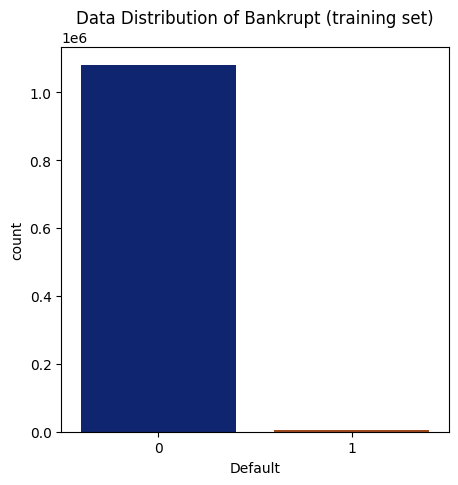

Imbalance Ratio is:293.4822155851208
 % of default is :0.003395790805271728


In [18]:
plt.figure(figsize=(5,5))
sns.countplot(x=train_df["Default"], palette="dark")
plt.title("Data Distribution of Bankrupt (training set)")
plt.show()
majority_class_samples=train_df["Default"].loc[train_df["Default"]==0]
minority_class_samples=train_df["Default"].loc[train_df["Default"]==1]
Imbalance_Ratio= len(majority_class_samples)/len(minority_class_samples)
percentage = len(minority_class_samples)/(len(minority_class_samples)+len(majority_class_samples))
print(f"Imbalance Ratio is:{Imbalance_Ratio}")
print(f" % of default is :{percentage}") 

In [19]:
# drop unecessary columns
train_df.drop(["CompNo", "year", "month",], axis=1, inplace=True)
validation_df.drop(["CompNo", "year", "month"], axis=1, inplace=True)
test_df.drop(["CompNo", "year", "month"], axis=1, inplace=True)

In [20]:
x_train = train_df.drop('Default', axis=1)
y_train = train_df['Default']
x_validation = validation_df.drop('Default', axis=1)
y_validation = validation_df['Default']
x_test = test_df.drop('Default', axis=1)
y_test = test_df["Default"]

In [21]:
def get_num_cat_columns(dataframe):
    categorical_cols=dataframe.select_dtypes(include="object").columns
    numerical_cols=dataframe.select_dtypes(exclude="object").columns
    
    return categorical_cols, numerical_cols

In [22]:
categorical_cols, numerical_cols= get_num_cat_columns(x_train)

In [23]:
def Winsorization_Method(columns, x_train, y_train , a, b):
    outliers=[]

    for col in columns:
        q1= np.percentile(x_train[col], a)
        q2= np.percentile(x_train[col],b)
        
        for pos in range(len(x_train)):
            if x_train[col].iloc[pos]>q2 or x_train[col].iloc[pos]<q1:
                outliers.append(pos) 
                
    outliers= set(outliers)                   # remove the duplicates from the outliers
    outliers= list(outliers)
    
    ratio= round(len(outliers)/len(x_train)*100, 2)                       # Ratio of outliers
    x_train.drop(x_train.index[outliers], inplace=True)    # remove the outliers from the training dataset
    y_train.drop(y_train.index[outliers], inplace=True)
    
    
    
    return ratio, x_train, y_train

In [25]:
ratio, x_train, y_train= Winsorization_Method(numerical_cols, x_train, y_train,a=0.3,b=99.7)
print(f"Ratio of Outliers Detected in the dataset:{ratio}")

Ratio of Outliers Detected in the dataset:14.33


In [26]:
# shape of data after removing the outliers in the training data
x_train.shape,x_test.shape,x_validation.shape ,y_train.shape, y_test.shape, y_validation.shape

((929128, 46), (36537, 46), (58299, 46), (929128,), (36537,), (58299,))

In [27]:
def to_csv(path):
    x_train.to_csv(path + "X_train_winsorized.csv", index=False)
    x_test.to_csv(path + "X_test.csv", index=False)
    x_validation.to_csv(path + "X_validation.csv", index=False)
    y_train.to_csv(path + "Y_train_winsorized.csv", index=False)
    y_test.to_csv(path + "Y_test.csv", index=False)
    y_validation.to_csv(path + "Y_validation.csv", index=False)

to_csv("../Dataset/6months/")